# Digging Into Deep Time and Deep Cover

<a href="https://doi.org/10.5281/zenodo.3875779"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.3875779.svg" align="right" alt="doi: 10.5281/zenodo.3875779" style="padding: 0px 10px 10px 0px"></a>
<a href="https://github.com/morganjwilliams/gs2020-diggingdeeper/blob/master/LICENSE"><img src="https://img.shields.io/badge/License-MIT-blue.svg" align="right" alt="License: MIT" style="padding: 0px 10px 10px 0px"></a>


<span id='authors'><b>Morgan Williams <a class="fa fa-twitter" aria-hidden="true" href="https://twitter.com/metasomite" title="@metasomite"></a></b>, Jens Klump, Steve Barnes and Fang Huang; </span>
<span id='affiliation'><em>CSIRO Mineral Resources</em></span>


### Contents

| [**Abstract**](./00_overview.ipynb) | **Introduction**                                                    | [**Examples**](./00_overview.ipynb#Examples)            | [**Tools**](./00_overview.ipynb#Leveraging-the-Scientific-Python-Ecosystem) | [**Insights**](./00_overview.ipynb#Insights) |
|:-----|:-----|:-----|:-----|:-----|
|  | [Minerals Exploration](./00_overview.ipynb#An-Evolving-Role-of-Geochemistry-in-Mineral-Exploration)  | [Classification](./011_classification.ipynb) |  |  |
|  | [Data Driven Geochem](./00_overview.ipynb#Data-Driven-Geochemistry) | [Data Visualization](./012_datavis.ipynb) |  |  |

## Data Exploration

While there are many avenues to improve the robustness of data analysis in research, there are also opportunities to expand how we explore our datasets, potentially allowing us to find 'latent' features faster, or provide additional perspectives and context.

* Adding context to our data - what does it mean in the 'scheme of things'
* Making the most of the dimensions we have, but acknowledging that we have limited ability to understand complex data - dimensional reduction, smart visualisations (e.g. distance vs area vs volume).

**Key Messages**:

### Visualizing Uncertainty

While some classification problems can be adapted to versions of binary classifications, most involve multiple classes. In the case of probabilistic classification, model outputs are typically a multidimensional array of multiclass probability estimates, where the relative uncertainty of classification is more difficult to ascertain, and harder again to visualize for a larger group of samples. One measure which is related to the uncertainty of classification is the [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)), which effectively measures the distribution of probability among a number of potential classes:

\\[S = - \sum{P_i \cdot log(P_i)} \\]

Where samples are predicted to belong to one of mutliple classes with high relative probability, entropy is low. Where a sample is predicted to belong to mutliple classes with more or less equal probability, entropy is high. This is a particularly useful measure for quick visualisations of classification outputs, where the entropy is rescaled to \\([0,1]\\) to give a relative opacity. 

To quickly demonstrate this, below we build a simple model for a multi-class classification problem (classes $A, B, C$) and investigate the probabilistic outputs of the model predictions for a few sample. For each sample the probabiltistic outputs are shown as bar charts across each of the three classes, and the opacity of the bars modulated by the information entropy for these probabilities. The entropy $S$ and opacity $\alpha$ are shown in the top right of each subplot, and the inverse linear relationship between entropy and opacity is shown in the last subplot.

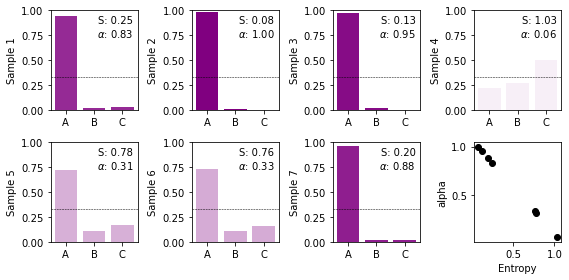

In [1]:
import numpy as np
import sklearn.datasets
from scipy.stats import entropy
import matplotlib.pyplot as plt
from pyrolite.util.skl.pipeline import SVC_pipeline
from pyrolite.util.skl.vis import alphas_from_multiclass_prob
from pyrolite.util.plot import DEFAULT_DISC_COLORMAP

from pyrolite.util.plot.axes import share_axes

np.random.seed(82)

wine = sklearn.datasets.load_wine()
data, target = wine["data"], wine["target"]
svc = SVC_pipeline(probability=True, verbose=0)
wine_gs = svc.fit(data, target);

fig, ax = plt.subplots(2, 4, figsize=(8,4))
ax=ax.flat
share_axes(ax[:-1], which='xy')

cm = plt.cm.Greens

ax[0].set_ylim(0, 1)
n = 7
dt = wine_gs.predict_proba(data)[::7][:n]
dtalpha = alphas_from_multiclass_prob(dt, method='entropy')
for ix in range(n):
    ax[ix].axhline(1/3, color='k', ls='--', lw=0.5)
    ax[ix].bar(['A', 'B', 'C'], dt[ix], alpha=dtalpha[ix], facecolor='purple')
    ax[ix].set_ylabel('Sample {}'.format(ix+1))
    ax[ix].annotate("S: {:.2f}".format(entropy(dt[ix]))+"\n"+r"$\alpha$: {:.2f}".format(dtalpha[ix]), 
                    xy=(0.95, 0.95), 
                    xycoords='axes fraction',
                    ha='right', 
                    va='top')

ax[-1].scatter([entropy(dt[ix]) for ix in range(n)], [dtalpha[ix]for ix in range(n)], color='k')
ax[-1].set_xlabel('Entropy')
ax[-1].set_ylabel('alpha')
plt.tight_layout()

We can use the same method to provide a measure of uncertainty which is usable in a scatter plot, without having to resort to effects which distort the visualisation (e.g. size and shape). This allows the 'boundaries' of classes where classification is uncertain to be effectively visualised, and provides information about the performance of the classifier with respect to the distribution of the input variables:

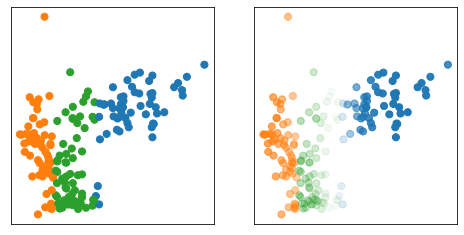

In [12]:
# choose some informative features to use for this projection
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(data, target)
f0, f1 = np.argsort(clf.feature_importances_)[::-1][:2]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].set_xticks([])
ax[0].set_yticks([])

_x, _y = data[:, f0],data[:, f1],

classes = wine_gs.predict(data)
c = DEFAULT_DISC_COLORMAP(classes)

ax[0].scatter(_x, _y, c=c, s=50)

c[:, -1] = alphas_from_multiclass_prob(wine_gs.predict_proba(data), method='entropy')
ax[1].scatter(_x, _y, c=c, s=50);

This is a relatively simple example, and to demonstrate what this looks like for a real geochemical dataset, we can repeat the exercise from the previous notebook and incorporate the use of entropy into our visualisation. Here we build a support vector classifier (SVC) with the same parameters as before.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import FeatureUnion, make_pipeline
set_config(display='diagram')


import pyrolite.comp
import pyrolite.geochem
from pyrolite.util.units import scale
from pyrolite.util.plot import DEFAULT_DISC_COLORMAP
from pyrolite.util.plot.legend import proxy_line
from pyrolite.util.skl.select import CompositionalSelector
from pyrolite.util.skl.vis import plot_confusion_matrix, plot_mapping
from pyrolite.util.skl.pipeline import SVC_pipeline
from pyrolite.util.skl.transform import CLRTransform, LinearTransform

df = pd.read_csv('https://storage.googleapis.com/aegc2019/ueki2018.csv')

class_dict = {c: ix for ix, c in enumerate(df['Class'].unique())}
X = df[[c for c in df.columns if c!='Class']]
y = df['Class'].map(class_dict)

XX_train, XX_test, yy_train, yy_test = train_test_split(
    X, y, stratify=y, test_size=0.3
)

gs = SVC_pipeline(
    verbose=0,
    probability=True,
    scaler=StandardScaler(),
    transform = FeatureUnion([
        ('abundances --> CLR', make_pipeline(CompositionalSelector(), CLRTransform())), 
        ('isotopes', CompositionalSelector(inverse=True))
                        ]),
    param_grid=dict(
        svc__gamma=np.logspace(-2.3, -0.85, 5),
        svc__C=np.logspace(-0.5, 2, 5),  # limit C parameter to avoid overfitting
    ),
    cv=5
)
gs.fit(XX_train, yy_train)
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('featureunion',
                                        FeatureUnion(transformer_list=[('abundances '
                                                                        '--> '
                                                                        'CLR',
                                                                        Pipeline(steps=[('compositionalselector',
                                                                                         CompositionalSelector()),
                                                                                        ('clrtransform',
                                                                                         CLRTransform())])),
                                                                       ('isotopes',
                                                                        CompositionalSelector(inverse=True))])),
                                       ('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(cache_size=500,
                                            class_weight='balanced',
                                            decision_function_shape='ovo',
                                            probability=True))]),
             n_jobs=4,
             param_grid={'svc__C': array([  0.31622777,   1.33352143,   5.62341325,  23.71373706,
       100.        ]),
                         'svc__gamma': array([0.00501187, 0.01154782, 0.02660725, 0.06130558, 0.14125375])})

In [91]:
from pyrolite.util.skl.vis import alphas_from_multiclass_prob

Y = gs.predict(X)
c = DEFAULT_DISC_COLORMAP(Y)
ps = gs.predict_proba(X)
c[:, -1] = alphas_from_multiclass_prob(ps)

samples = np.random.choice(X.index.size, X.index.size//2, replace=False)
xsample = X.iloc[samples, :]
ysample = Y[samples]
csample = c[samples]
tfm_xsample = gs.estimator['standardscaler'].fit_transform(
                gs.estimator['featureunion'].transform(xsample)
              )

We can again plot our Pearce diagram, this time using the entropy measure. As our classifier has high overall accuracy, it's not too surprising to not see too many faded symbols, but a few of the outliers falling beyond the bounds of most of the data the classifier was trained on are nicely distinguished:

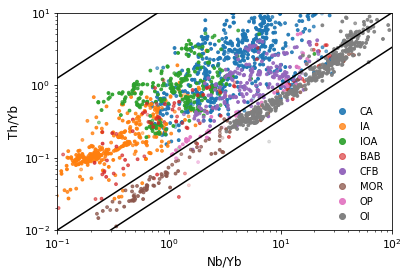

In [92]:
from pyrolite.plot.templates import pearceThNbYb
fig, ax = plt.subplots(1)
pearceThNbYb(ax)
df.pyrochem.add_ratio("Th/Yb")
df.pyrochem.add_ratio("Nb/Yb")

for ID in df.Class.unique():
    subdf = df.loc[df.Class==ID, :]
    subdf[['Nb/Yb', 'Th/Yb']].pyroplot.scatter(color=c[df.Class==ID, :], ax=ax, s=8)
    
ax.legend([proxy_line(c=coll.get_facecolors()[0], marker='o', ls='none') for coll in ax.collections],
          df.Class.unique(),
          frameon=False,
          facecolor=None);

### Dimensional Reduction for Visualization

One of the key challenges of working with and visualizing geochemical data is the relatively high dimensionality. We can get some idea of the structure of our dataset in two or even three-dimensions, especially when we choose important variables or *projections* (e.g. along two principal or independent components). However, the higher dimensional structure remains relatively opaque, and to access this for visualization purposes we need to reduce the overall dimensionality.

Manifold learning methods attempt to generalize projections like PCA to find non-linear structure in datasets, and produce a low-dimensional representation of higher dimensional space. Below we use two such methods (TSNE and UMAP) to dig into some of this higher-dimensional structure. For more information on manifold methods, see the [scikit-learn overview](https://scikit-learn.org/stable/modules/manifold.html).

First, let's see what a 2D representation of our basalt dataset looks like using TSNE (t-distributed Stochastic Neighbor Embedding; [van der Maaten and Hinton, 2008]).

[van der Maaten and Hinton, 2008]: http://www.jmlr.org/papers/v9/vandermaaten08a.html "van der Maaten, L., Hinton, G., 2008. Visualizing Data using t-SNE. Journal of Machine Learning Research 9, 2579–2605."

In [93]:
tfm = sklearn.manifold.TSNE(n_components=2, init='pca')
mapped = tfm.fit_transform(tfm_xsample)

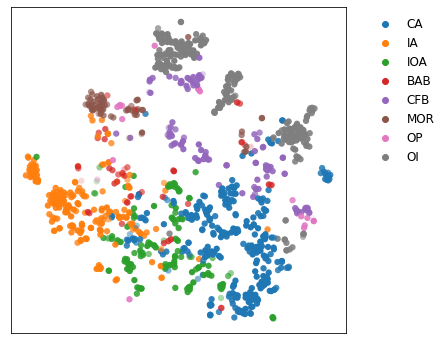

In [97]:
fig, ax = plt.subplots(1,figsize=(6, 6))
s=40

ax.scatter(*mapped.T, c=csample, s=s, edgecolors="none")

ax.set_xticks([])
ax.set_yticks([])

ax.legend([proxy_line(c=DEFAULT_DISC_COLORMAP(ix), ls='none', marker='o') for c, ix in class_dict.items()], 
             [c for c in class_dict.keys()], 
             bbox_to_anchor=(1.05, 1.0), 
             loc='upper left', 
             frameon=False, 
             fontsize=12);

Uniform Manifold Approximation and Projection (UMAP) is another dimension reduction technique which can be used in a very similar way to other manifold methods within scikit-learn ([McInnes2018]), with the added flexibility of being able transform new/novel data. This is particularly useful for visualizing training and testing data together, but can also be applied to map reference compositions and boundaries into the projected space. UMAP can also be used for semi-supervised and supervised dimensional reduction and metric learning, but this is beyond the scope of these notebooks. The technique is based on a specific set of assumptions which may be violated in practice, but it remains effective for the uses described here.

[McInnes2018]: https://doi.org/10.21105/joss.00861 "McInnes, L., Healy, J., Saul, N., Grossberger, L., 2018. UMAP: uniform manifold approximation and projection. The Journal of Open Source Software 3, 861."

In [84]:
import umap.umap_ as umap  # required in case of umap install errors

reducer = umap.UMAP(n_neighbors=200, min_dist=0.1)
embedding = reducer.fit_transform(tfm_xsample)

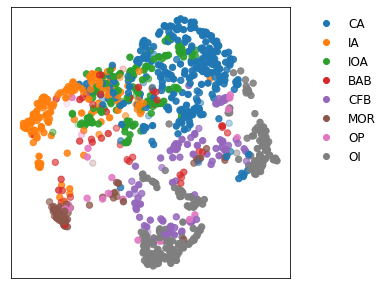

In [85]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.scatter(*embedding.T, 
           c=csample,
           s=s)
ax.set_xticks([])
ax.set_yticks([])

ax.legend([proxy_line(c=DEFAULT_DISC_COLORMAP(ix), ls='none', marker='o') for c, ix in class_dict.items()], 
          [c for c in class_dict.keys()],
          bbox_to_anchor=(1.05, 1.0), 
          loc='upper left', 
          frameon=False, 
          fontsize=12);

You can also change the number of components, for example to generate 3D figures:

<!--
### Using Manifold Methods for Visualizing Covariate Shift
# projecting new data into manifold space
-->

In [77]:
threeDreducer = umap.UMAP(n_components=3, n_neighbors=100, min_dist=0.1)
threeDembedding = threeDreducer.fit_transform(tfm_xsample)

In [78]:
import ipyvolume as ipv

fig = ipv.figure()
fig = ipv.quickscatter(*threeDembedding.T,
                 color=csample,
                 size=2, 
                 marker='sphere')
ipv.show()

------

### Index

| [**Abstract**](./00_overview.ipynb) | **Introduction**                                                    | [**Examples**](./00_overview.ipynb#Examples)            | [**Tools**](./00_overview.ipynb#Leveraging-the-Scientific-Python-Ecosystem) | [**Insights**](./00_overview.ipynb#Insights) |
|:-----|:-----|:-----|:-----|:-----|
|  | [Minerals Exploration](./00_overview.ipynb#An-Evolving-Role-of-Geochemistry-in-Mineral-Exploration)  | [Classification](./011_classification.ipynb) |  |  |
|  | [Data Driven Geochem](./00_overview.ipynb#Data-Driven-Geochemistry) | [Data Visualization](./012_datavis.ipynb) |  |  |